#  Sentiment Analysis on Social Media Data

In [35]:
#!pip install wordcloud

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
#!pip install textblob

In [4]:
#For Sentiment Analysis
from textblob import TextBlob

In [5]:

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [6]:
# Load the dataset
df = pd.read_csv("/home/user/Documents/Sentimental analysis/Sentiment dataset.csv")

In [7]:
#Check the first 5 rows
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [8]:
# Check the summary
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB
None


In [9]:
# Drop irrelevant columns if any (e.g., 'Unnamed: 0')
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [10]:
df.head(3)

,Unnamed: 0.1,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15


In [11]:
# Check for missing values in 'Text'
print("\nMissing values in 'Text':", df['Text'].isnull().sum())


Missing values in 'Text': 0


In [12]:
# Drop rows with missing text
df = df.dropna(subset=['Text'])

In [13]:
# Reset index
df = df.reset_index(drop=True)

In [14]:
df.tail()

,Unnamed: 0.1,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
727,728,Collaborating on a science project that receiv...,Happy,2017-08-18 18:20:00,ScienceProjectSuccessHighSchool,Facebook,#ScienceFairWinner #HighSchoolScience,20.0,39.0,UK,2017,8,18,18
728,729,Attending a surprise birthday party organized ...,Happy,2018-06-22 14:15:00,BirthdayPartyJoyHighSchool,Instagram,#SurpriseCelebration #HighSchoolFriendship,25.0,48.0,USA,2018,6,22,14
729,730,Successfully fundraising for a school charity ...,Happy,2019-04-05 17:30:00,CharityFundraisingTriumphHighSchool,Twitter,#CommunityGiving #HighSchoolPhilanthropy,22.0,42.0,Canada,2019,4,5,17
730,731,"Participating in a multicultural festival, cel...",Happy,2020-02-29 20:45:00,MulticulturalFestivalJoyHighSchool,Facebook,#CulturalCelebration #HighSchoolUnity,21.0,43.0,UK,2020,2,29,20
731,732,Organizing a virtual talent show during challe...,Happy,2020-11-15 15:15:00,VirtualTalentShowSuccessHighSchool,Instagram,#VirtualEntertainment #HighSchoolPositivity,24.0,47.0,USA,2020,11,15,15


### Text pre-processing

Convert to lowercase, remove URLs, remove user mentions & hashtags, remove punctuation and digits, tokenize, remove stopwords, lemmatization.

In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

In [16]:
df['Cleaned_Text'] = df['Text'].apply(preprocess_text)

In [17]:
print("\nCleaned sample:")
df[['Text', 'Cleaned_Text']].head()


Cleaned sample:


,Text,Cleaned_Text
0,Enjoying a beautiful day at the park! ...,enjoying beautiful day park
1,Traffic was terrible this morning. ...,traffic terrible morning
2,Just finished an amazing workout! 💪 ...,finished amazing workout
3,Excited about the upcoming weekend getaway! ...,excited upcoming weekend getaway
4,Trying out a new recipe for dinner tonight. ...,trying new recipe dinner tonight


In [18]:
df.head(3)

,Unnamed: 0.1,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Cleaned_Text
0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12,enjoying beautiful day park
1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8,traffic terrible morning
2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15,finished amazing workout


### SENTIMENT ANALYSIS USING TEXTBLOB

In [19]:
# Sentiment analysis using TextBlob involves analyzing the polarity of the text.
# Polarity is a float value within the range [-1.0, 1.0], where:
# -1.0 indicates a negative sentiment,
#  0.0 indicates a neutral sentiment, and
#  1.0 indicates a positive sentiment.

In [20]:
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [21]:
df['Predicted_Sentiment'] = df['Cleaned_Text'].apply(get_sentiment)

In [22]:
print("\nComparison of original vs predicted sentiment (first 10 rows):")
df[['Sentiment', 'Predicted_Sentiment']].head(10)


Comparison of original vs predicted sentiment (first 10 rows):


,Sentiment,Predicted_Sentiment
0,Positive,Positive
1,Negative,Negative
2,Positive,Positive
3,Positive,Positive
4,Neutral,Positive
5,Positive,Negative
6,Positive,Positive
7,Positive,Positive
8,Negative,Neutral
9,Neutral,Negative


### VISUALIZATION

/tmp/ipykernel_367164/4209634321.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Predicted_Sentiment', data=df, palette='viridis')


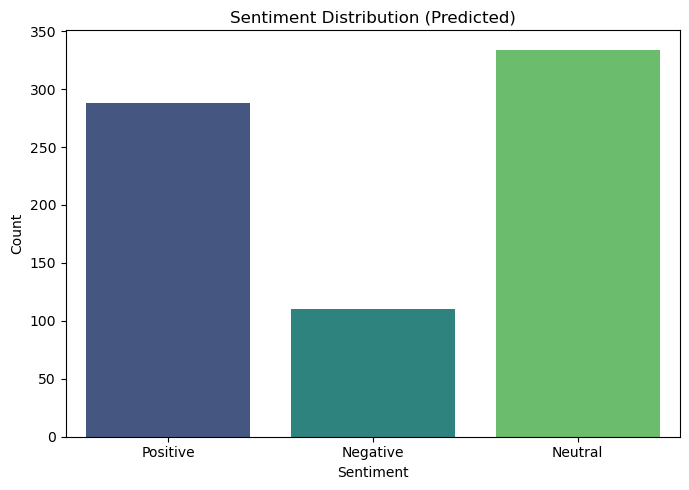

In [23]:
#Sentiment Distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Predicted_Sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution (Predicted)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()


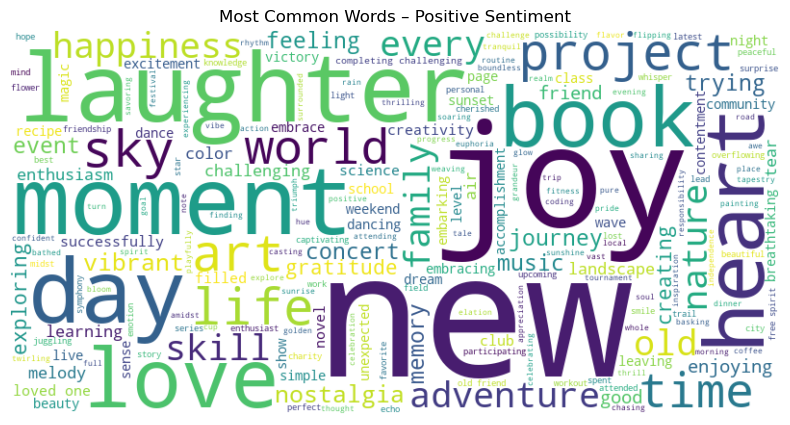

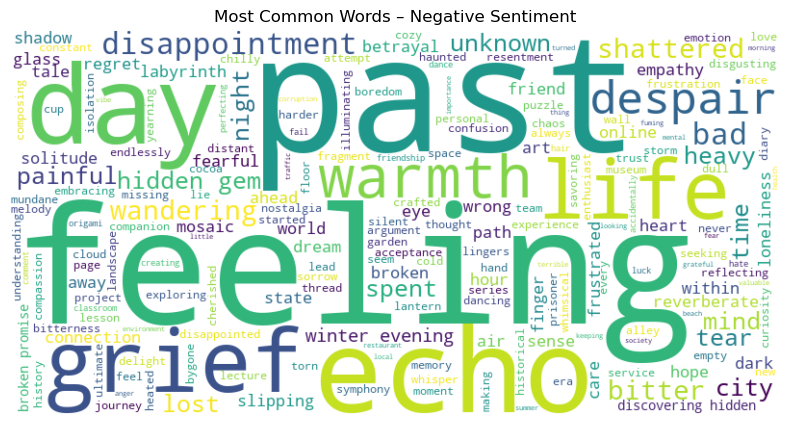

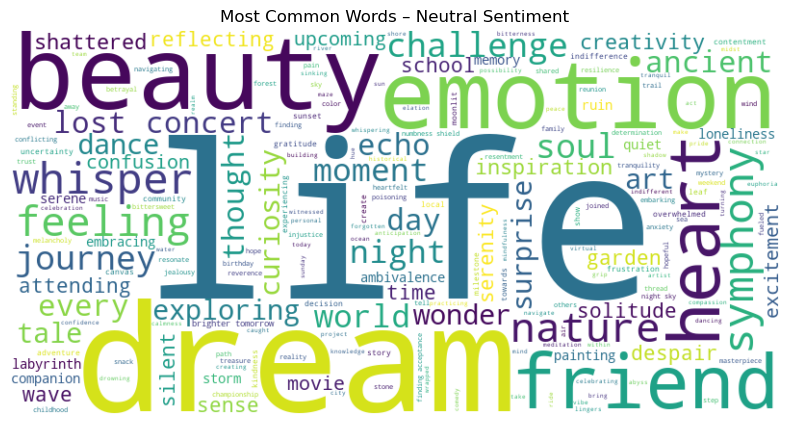

In [24]:
#Word Cloud by Sentiment
sentiments = ['Positive', 'Negative', 'Neutral']
for sentiment in sentiments:
    text = " ".join(df[df['Predicted_Sentiment'] == sentiment]['Cleaned_Text'])
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(8, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Most Common Words – {sentiment} Sentiment')
        plt.tight_layout()
        plt.savefig(f'wordcloud_{sentiment.lower()}.png')
        plt.show()
    else:
        print(f"No text data for {sentiment} sentiment.")

In [25]:
# The plots above show words used more often in happy, sad, or neutral posts.

In [26]:
#Compare original label distribution
print("\nOriginal sentiment label counts:")
print(df['Sentiment'].value_counts())


Original sentiment label counts:
Sentiment
Positive               44
Joy                    42
Excitement             32
Happy                  14
Neutral                14
                       ..
Vibrancy                1
Culinary Adventure      1
Mesmerizing             1
Thrilling Journey       1
Winter Magic            1
Name: count, Length: 279, dtype: int64


In [27]:
#EVALUATION IF ORIGINAL LABELS ARE STANDARD
#Standardize original labels
df['Sentiment_Clean'] = df['Sentiment'].str.strip().str.title()

In [28]:
# Map variations like 'Anger' - 'Negative', 'Happy' - 'Positive'
emotion_to_sentiment = {
    'Positive': 'Positive',
    'Negative': 'Negative',
    'Neutral': 'Neutral',
    'Anger': 'Negative',
    'Fear': 'Negative',
    'Sadness': 'Negative',
    'Disgust': 'Negative',
    'Happiness': 'Positive',
    'Joy': 'Positive',
    'Love': 'Positive',
    'Amusement': 'Positive',
    'Enjoyment': 'Positive',
    'Admiration': 'Positive',
    'Affection': 'Positive',
    'Awe': 'Positive',
    'Surprise': 'Positive',
    'Acceptance': 'Positive',
    'Adoration': 'Positive',
    'Anticipation': 'Positive',
    'Bitter': 'Negative',
    'Calmness': 'Positive',
    'Confusion': 'Neutral',
    'Excitement': 'Positive',
    'Kind': 'Positive',
    'Pride': 'Positive',
    'Shame': 'Negative',
    'Despair': 'Negative',
    'Grief': 'Negative',
    'Loneliness': 'Negative',
    'Jealousy': 'Negative',
    'Resentment': 'Negative',
    'Frustration': 'Negative',
    'Boredom': 'Negative',
    'Anxiety': 'Negative',
    'Intimidation': 'Negative',
    'Helplessness': 'Negative',
    'Envy': 'Negative',
    'Regret': 'Negative',
    'Elation': 'Positive',
    'Euphoria': 'Positive',
    'Contentment': 'Positive',
    'Serenity': 'Positive',
    'Gratitude': 'Positive',
    'Hope': 'Positive',
    'Empowerment': 'Positive',
    'Compassion': 'Positive',
    'Tenderness': 'Positive',
    'Arousal': 'Positive',
    'Enthusiasm': 'Positive',
    'Fulfillment': 'Positive',
    'Reverence': 'Positive',
    'Curiosity': 'Positive',
    'Indifference': 'Neutral',
    'Numbness': 'Neutral',
    'Melancholy': 'Negative',
    'Nostalgia': 'Neutral',
    'Ambivalence': 'Neutral',
    'Determination': 'Positive',
    'Zest': 'Positive',
    'Free-spirited': 'Positive',
    'Inspired': 'Positive',
    'Confident': 'Positive',
    'Bitterness': 'Negative',
    'Yearning': 'Neutral',
    'Fearful': 'Negative',
    'Apprehensive': 'Negative',
    'Overwhelmed': 'Negative',
    'Jealous': 'Negative',
    'Devastated': 'Negative',
    'Frustrated': 'Negative',
    'Envious': 'Negative',
    'Dismissive': 'Negative',
    'Thrill': 'Positive',
    'Overjoyed': 'Positive',
    'Motivation': 'Positive',
    'Blessed': 'Positive',
    'Appreciation': 'Positive',
    'Confidence': 'Positive',
    'Accomplishment': 'Positive',
    'Wonderment': 'Positive',
    'Optimism': 'Positive',
    'PlayfulJoy': 'Positive',
    'Mindfulness': 'Positive',
    'DreamChaser': 'Positive',
    'Elegance': 'Positive',
    'Whimsy': 'Positive',
    'Pensive': 'Neutral',
    'Harmony': 'Positive',
    'Creativity': 'Positive',
    'Radiance': 'Positive',
    'Wonder': 'Positive',
    'Rejuvenation': 'Positive',
    'Coziness': 'Positive',
    'ArtisticBurst': 'Positive',
    'Immersion': 'Positive',
    'Spark': 'Positive',
    'Marvel': 'Positive',
    'Heartbreak': 'Negative',
    'EmotionalStorm': 'Negative',
    'Betrayal': 'Negative',
    'Suffering': 'Negative',
    'Exhaustion': 'Negative',
    'Sorrow': 'Negative',
    'Darkness': 'Negative',
    'Desperation': 'Negative',
    'Ruins': 'Negative',
    'Desolation': 'Negative',
    'Isolation': 'Negative',
    'Loss': 'Negative',
    'Heartache': 'Negative',
    'Solitude': 'Neutral',
    'Positivity': 'Positive',
    'Kindness': 'Positive',
    'Friendship': 'Positive',
    'Success': 'Positive',
    'Exploration': 'Positive',
    'Amazement': 'Positive',
    'Romance': 'Positive',
    'Tranquility': 'Positive',
    'Grandeur': 'Positive',
    'Emotion': 'Neutral',
    'Energy': 'Positive',
    'Celebration': 'Positive',
    'Charm': 'Positive',
    'Ecstasy': 'Positive',
    'Hope': 'Positive',
    'Hypnotic': 'Positive',
     'Connection': 'Positive',
    'Iconic': 'Positive',
    'Touched': 'Positive',
    'Engagement': 'Positive',
    'Satisfaction': 'Positive',
    'Triumph': 'Positive',
    'Heartwarming': 'Positive',
    'Solace': 'Positive',
    'Breakthrough': 'Positive',
    'Imagination': 'Positive',
    'Vibrancy': 'Positive',
    'Mesmerizing': 'Positive',
    'Culinary Adventure': 'Positive',
    'Winter Magic': 'Positive',
    'Thrilling Journey': 'Positive',
    "Nature's Beauty": 'Positive',
    'Celestial Wonder': 'Positive',
    'Creative Inspiration': 'Positive',
    'Runway Creativity': 'Positive',
    "Ocean's Freedom": 'Positive',
    'Whispers of the Past': 'Neutral',
    'Relief': 'Positive',
    'Embarrassed': 'Negative',
    'Mischievous': 'Neutral',
    'Hate': 'Negative',
    'Bad': 'Negative',
    'Happy': 'Positive',
    'Neutral': 'Neutral'
}


In [29]:
# Map to standard sentiment
df['Sentiment_Standard'] = df['Sentiment_Clean'].map(emotion_to_sentiment)

In [30]:
# Drop rows where mapping failed 
df = df.dropna(subset=['Sentiment_Standard'])

In [31]:
# Evaluate accuracy
accuracy = (df['Sentiment_Standard'] == df['Predicted_Sentiment']).mean()
print(f"\nApproximate accuracy vs human-labeled sentiment: {accuracy:.2%}")


Approximate accuracy vs human-labeled sentiment: 47.32%


In [32]:
# The accuracy variable represents the percentage of cases where the predicted sentiment matches the standardized sentiment.
# It is calculated as the mean of the boolean comparison between 'Sentiment_Standard' and 'Predicted_Sentiment' columns in
# the dataframe.In this case, the accuracy is approximately 47.32%, which indicates that the model's predictions align with
# the human-labeled sentiments in about 47.32% of the cases.

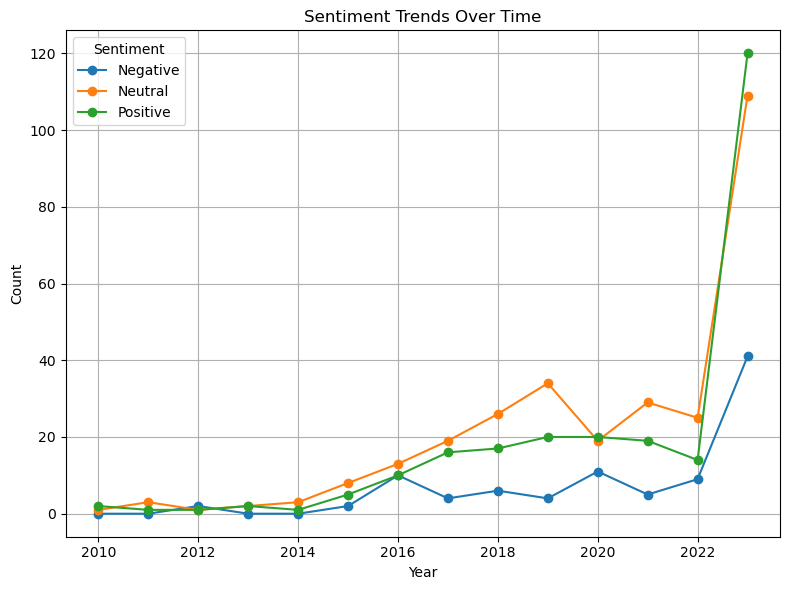

In [33]:
# Group by Year and Sentiment to analyze sentiment trends over time
time_sentiment = df.groupby(['Year', 'Predicted_Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment trends over the years
time_sentiment.plot(kind='line', figsize=(8, 6), marker='o')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.grid()
plt.tight_layout()
plt.savefig('time_based_sentiment_analysis.png')
plt.show()


In [34]:
# The plot shows X-axis (bottom): The Year – from 2010 to 2023.
# Y-axis (side): The Count – how many posts were labeled as Positive, Negative, or Neutral.
# Three Lines:
# Green Line = Positive (Happy, excited, grateful posts)
# Orange Line = Neutral (Just facts, no strong feelings)
# Blue Line = Negative (Sad, angry, frustrated posts)

# Early Years (2010–2015): All three lines are very low — only a few posts each year.
# Middle Years (2016–2021): Everything starts going up slowly.
# In 2022, all three lines jump up. People got way more active on social media in 2022-2023.

In [36]:
#save the new csv file
df.to_csv('analysed_sentiment_data.csv', index=False)